In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', -1)

In [4]:
data = pd.read_csv('cashflowforecast.csv')
data.columns = ['Month','Cashflow at the end']
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')
data.head(5)

,Cashflow at the end
Month,
2012-03-31,26731441
2012-09-30,71994170
2012-12-31,108633183
2013-03-31,186053544
2013-06-30,202489744


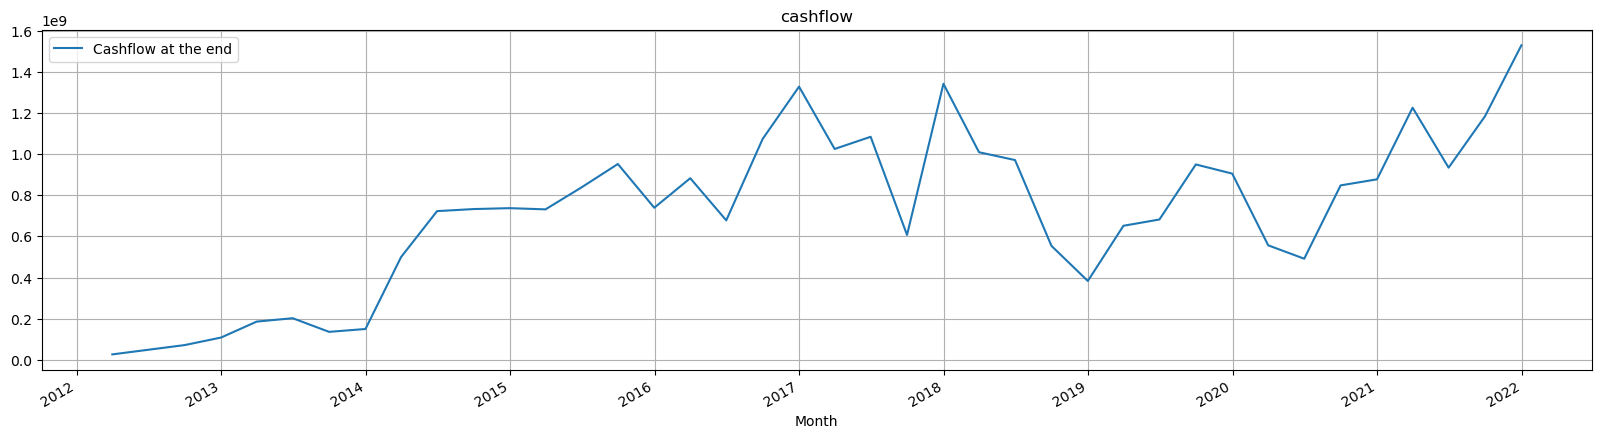

In [5]:
data.plot(figsize=(20, 5))
plt.grid()
plt.legend(loc='best')
plt.title('cashflow')
plt.show(block=False)

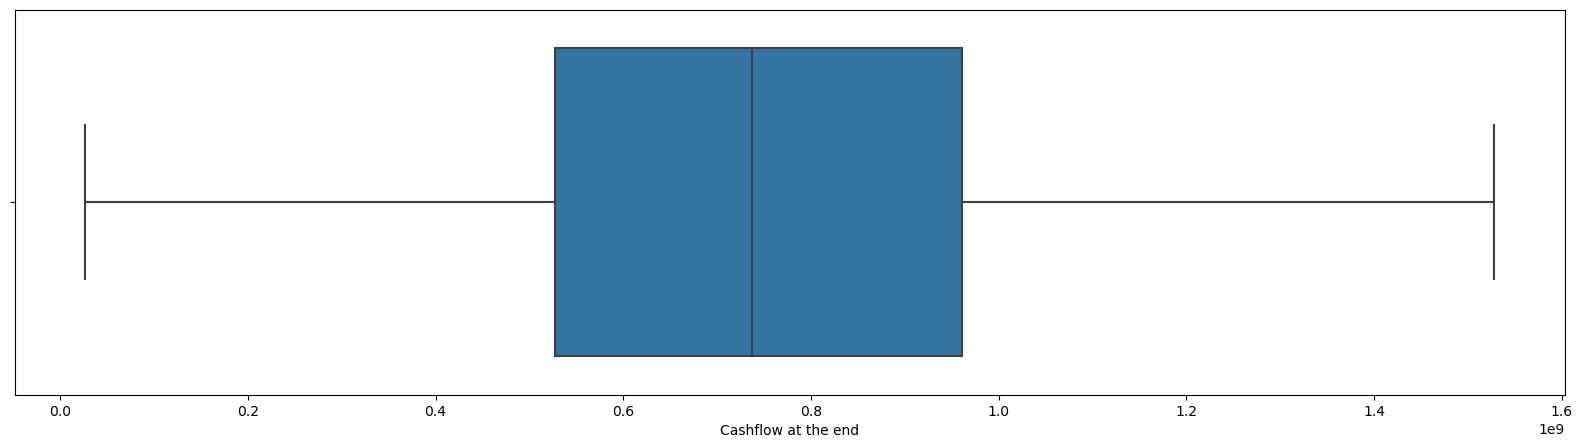

In [6]:
import seaborn as sns
fig = plt.subplots(figsize=(20, 5))
ax = sns.boxplot(x=data['Cashflow at the end'],whis=1.5)

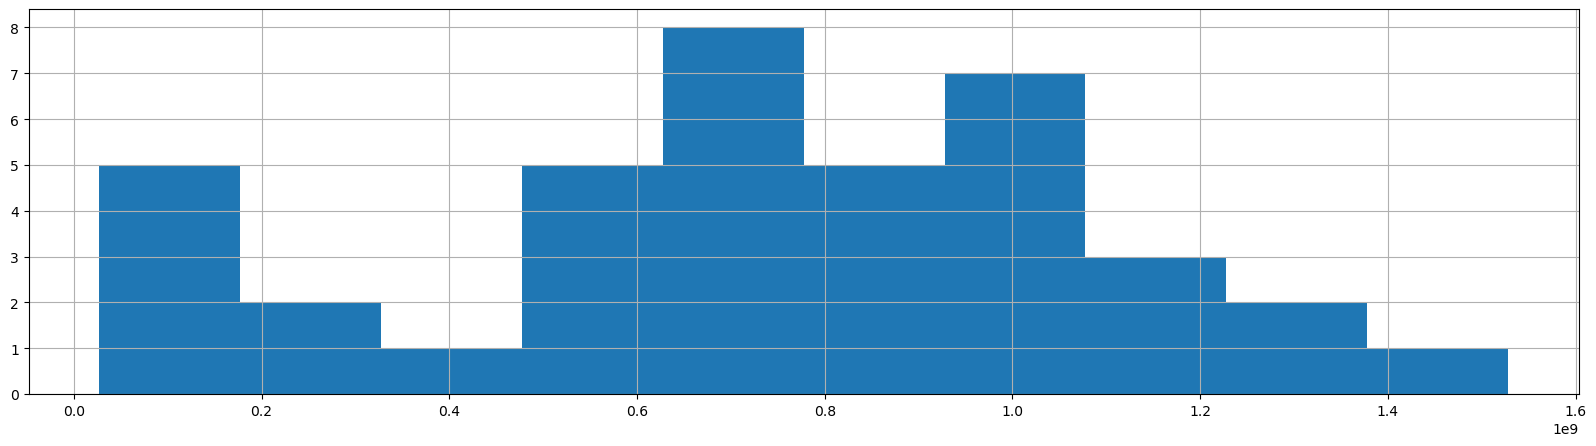

In [9]:
fig = (data["Cashflow at the end"].hist(figsize = (20,5)))

In [16]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data["Cashflow at the end"])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -1.722343
Critical Values @ 0.05: -2.95
p-value: 0.419639


In [18]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data['Cashflow at the end'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.598832
Critical Values @ 0.05: 0.46
p-value: 0.022743


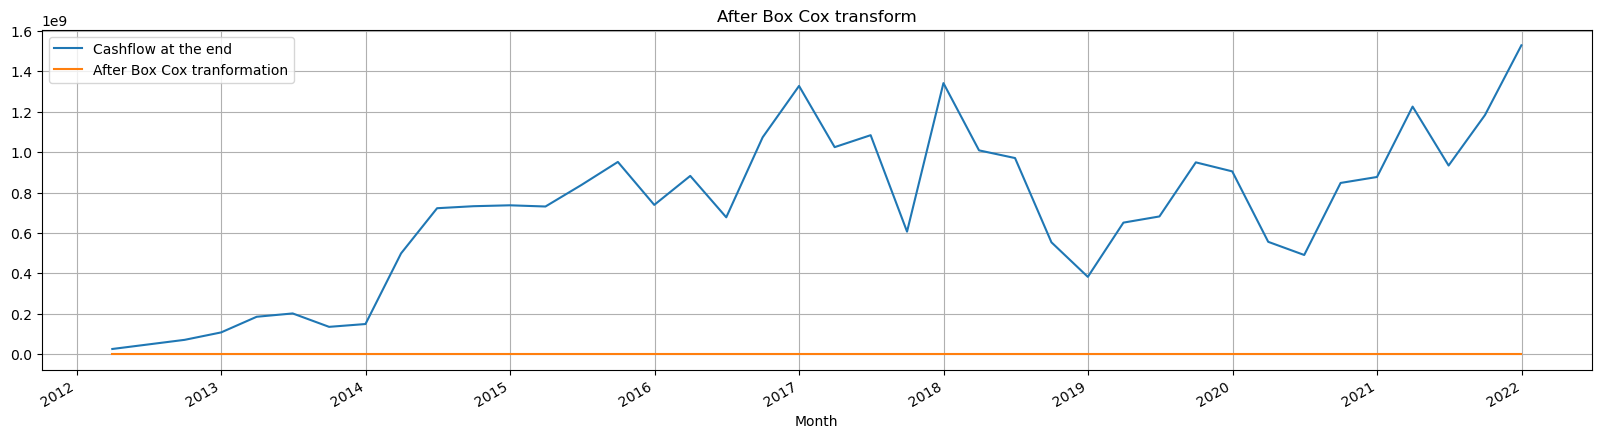

In [19]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Cashflow at the end'], lmbda=0), index = data.index)

data['Cashflow at the end'].plot(figsize=(20, 5))
plt.grid()
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

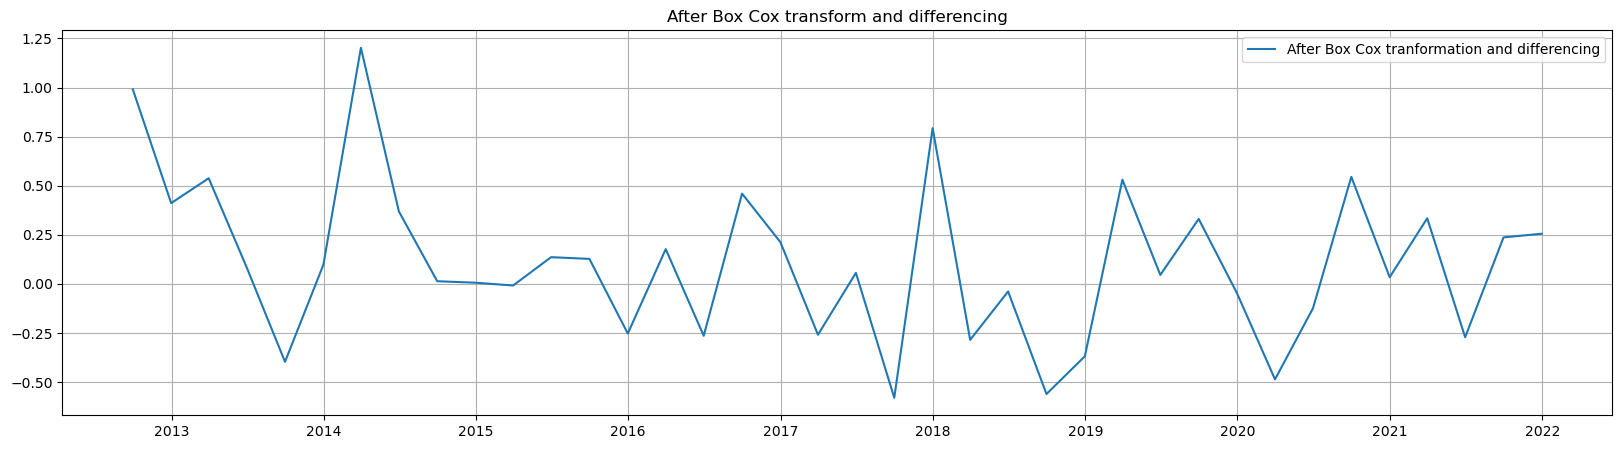

In [24]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [25]:
data_boxcox_diff.dropna(inplace=True)

In [26]:
data_boxcox_diff.tail()

Month
2020-12-31    0.034145
2021-03-31    0.334165
2021-06-30   -0.271526
2021-09-30    0.236962
2021-12-31    0.255591
dtype: float64

In [27]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -2.157553
Critical Values @ 0.05: -2.95
p-value: 0.222010


In [28]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.324101
Critical Values @ 0.05: 0.46
p-value: 0.100000


C:\Users\PoojaniRathnayakeBIS\AppData\Local\Temp\ipykernel_25440\3639712988.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(data_boxcox_diff)


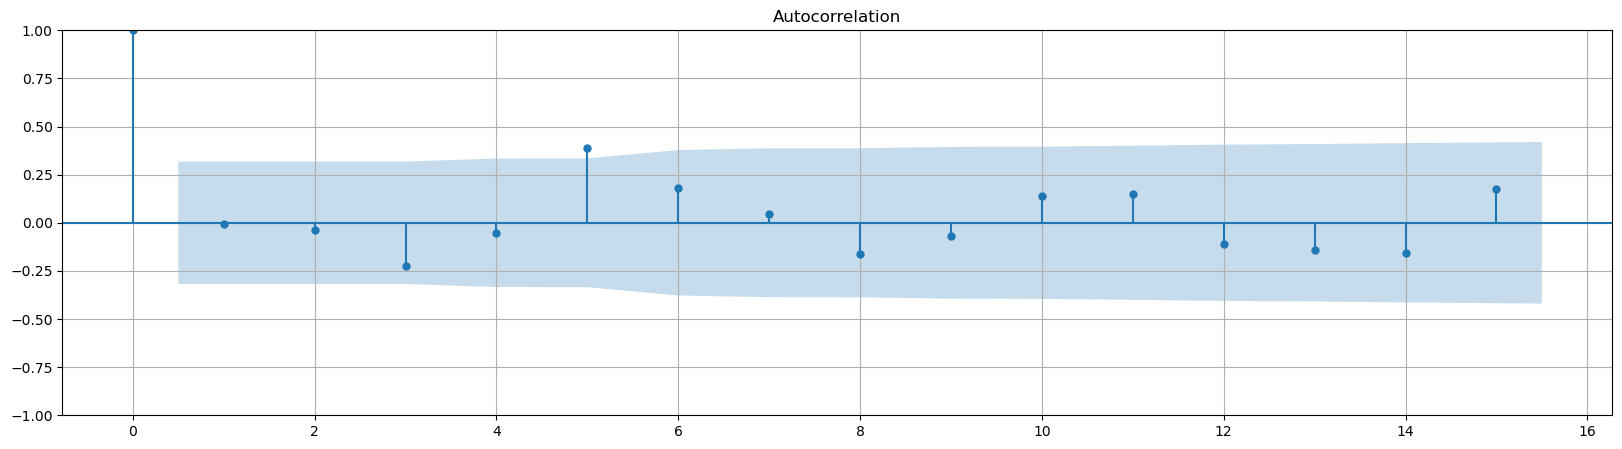

In [32]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(20,5))
plt.grid()
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 15)
plt.show()

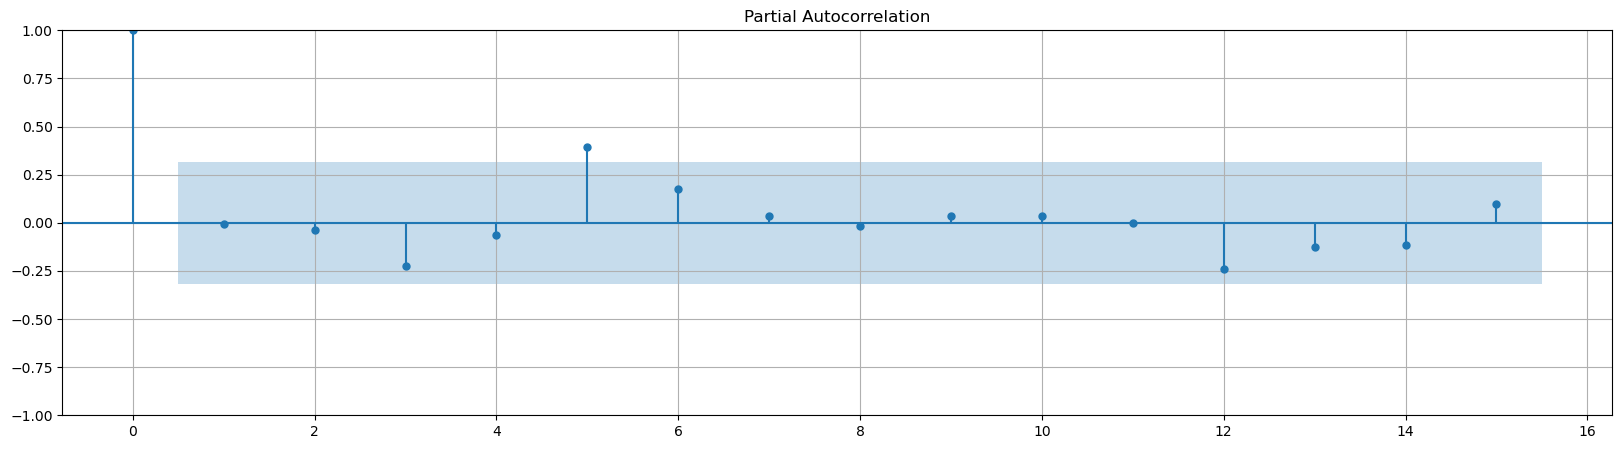

In [31]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(20,5))
plt.grid()
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 15)
plt.show()

In [34]:
train_len = 23
train = data[0:train_len]
test = data[train_len:]

In [35]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [36]:
train_data_boxcox_diff[:5]

Month
2012-09-30    0.990745
2012-12-31    0.411392
2013-03-31    0.538058
2013-06-30    0.084655
2013-09-30   -0.396685
dtype: float64

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ar.L1      -0.677492
ma.L1       0.998054
ar.S.L12   -0.904032
ma.S.L12   -0.603528
sigma2      0.033500
dtype: float64


D:\Anaconda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

KeyError: 'sarima_forecast'

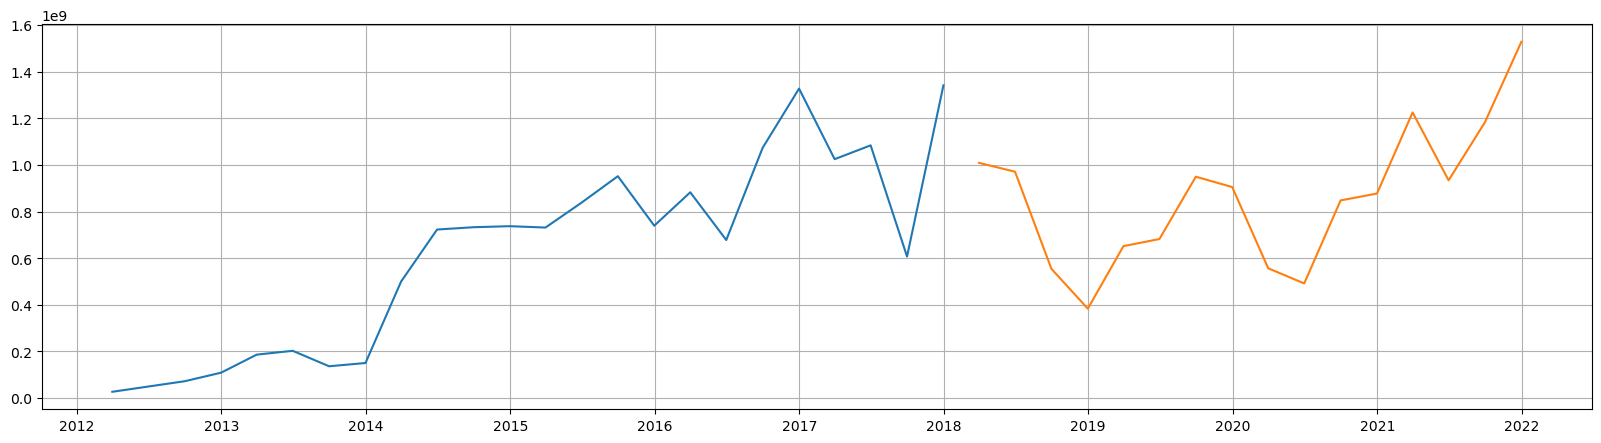

In [42]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['Cashflow at the end'], label='Train')
plt.plot(test['Cashflow at the end'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Cashflow at the end'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Cashflow at the end']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Cashflow at the end'])*100,2)

results = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })

results = results[['Method', 'RMSE', 'MAPE']]
results

KeyError: 'sarima_forecast'